In [16]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

import sys
from tqdm import tqdm

In [2]:
#downloading
!wget -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip \
         && unzip kagglecatsanddogs_5340.zip > /dev/null

In [3]:
! rm -rf ./PetImages/Cat/666.jpg ./PetImages/Dog/11702.jpg #remove the defective ones

In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

dataset = ImageFolder('./PetImages',
                      transform=Compose([Resize((224, 224)),
                                         ToTensor(),
                                         Normalize((0.5, 0.5, 0.5), (1, 1, 1))]))

train_set, test_set = torch.utils.data.random_split(
    dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

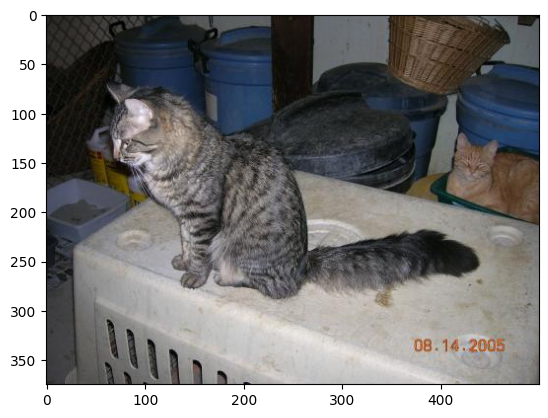

In [6]:
import glob

file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.imshow(plt.imread(file))

In [7]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.3MB/s]


In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
model.fc = nn.Linear(512, 2) #change last layer of nn on the Linear with 2 outputs

In [11]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cuda:0",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])  # .reshape((0, ))
    total_labels = np.array([])  # .reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, predicted.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

In [12]:
def validate(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(
                total_predictions, predicted.argmax(1).cpu().detach().numpy()
            )
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

In [22]:
def fit(model, epochs, train_data_loader, validation_data_loader, optimizer, criterion):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(1, epochs+1):
        # Train step
        print("--------------------------------")
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_data_loader, criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum=0.9)

In [23]:
fit(model, 10, train_dataloader, test_dataloader, optimizer, criterion)

---------------------
Train Epoch: 1
Loss: 0.1925 Accuracy: 96.6667: 100%|██████████| 79/79 [01:40<00:00,  1.27s/it]
Validation Epoch: 1
Loss: 0.1827 Accuracy: 93.3824: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]
---------------------
Train Epoch: 2
Loss: 0.3233 Accuracy: 80.0: 100%|██████████| 79/79 [01:38<00:00,  1.25s/it]
Validation Epoch: 2
Loss: 0.1146 Accuracy: 98.5294: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]
---------------------
Train Epoch: 3
Loss: 0.1857 Accuracy: 90.0: 100%|██████████| 79/79 [01:38<00:00,  1.24s/it]
Validation Epoch: 3
Loss: 0.1397 Accuracy: 96.3235: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]
---------------------
Train Epoch: 4
Loss: 0.0933 Accuracy: 100.0: 100%|██████████| 79/79 [01:38<00:00,  1.24s/it]
Validation Epoch: 4
Loss: 0.1109 Accuracy: 97.0588: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]
---------------------
Train Epoch: 5
Loss: 0.1646 Accuracy: 93.3333: 100%|██████████| 79/79 [01:37<00:00,  1.24s/it]
Validation Epoch: 5
Los